<a href="https://colab.research.google.com/github/vladmirkulov13/HPCLabs/blob/main/BilateralFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive


In [3]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627869 sha256=96a32b54b35b571864b209c494a159796d9c7c2c05eb03c8985b6bed7af5bc42
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=bbea38e312cc7a40e91b96bc02e51d69389d09d4ac3c0e015b0c5d391b4e764a
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pycuda pytools


In [7]:
import pycuda.autoinit
from pycuda.tools import make_default_context
make_default_context().get_device().name()

'Tesla K80'

Исходное изображение


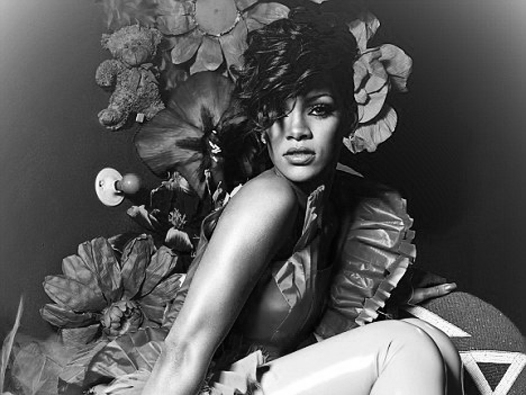


GPU


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).



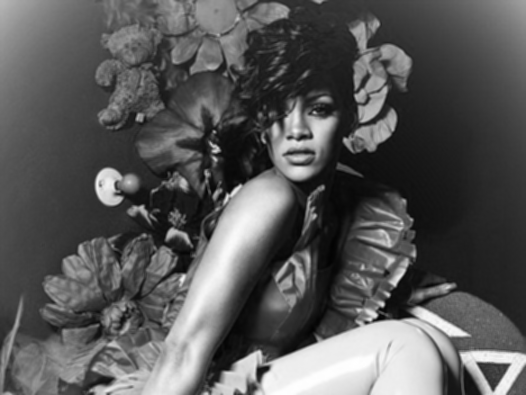

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in ubyte_scalars
  from ipykernel import kernelapp as app


GPU время 0.007 ms

CPU


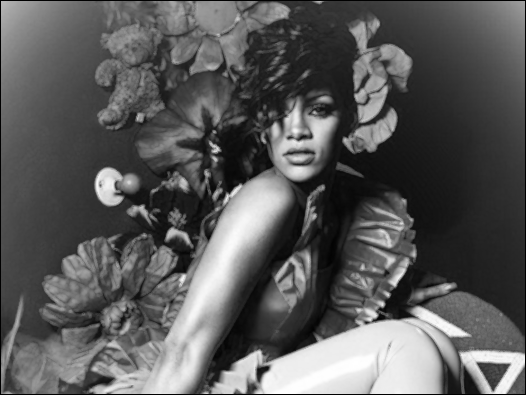

CPU время 18.130 ms

Ускорение:  2620.8669479813343


In [8]:
from pycuda import driver, compiler, gpuarray
import numpy as np
import cv2
import timeit
from google.colab.patches import cv2_imshow

def bil_pixel(image, i, j, sigma_d, sigma_r):    
    c = 0
    s = 0
    for k in range(i-1, i+2):
        for l in range(j-1, j+2):
            g = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
            i1 = image[k, l]
            i2 = image[i, j]
            r = np.exp(-((i1 - i2)** 2) / sigma_r ** 2)
            c += g*r
            s += g*r*image[k, l]
    result = s / c
    return result

def bilateral(image, sigma_d, sigma_r):
    n_image = np.zeros(image.shape)
    w = image.shape[0]
    h = image.shape[1]
    for i in range(1, w-1):
        for j in range(1, h-1):
            n_image[i, j] = bil_pixel(image, i, j, sigma_d, sigma_r)
    return n_image

IMG = '/content/яркая.bmp'
image = cv2.imread(IMG, cv2.IMREAD_GRAYSCALE)

print("Исходное изображение")
cv2_imshow(image)

M, N = image.shape
sigma_d = 200
sigma_r = 200

gpu_result = np.zeros((M, N), dtype=np.uint32)
block = (16, 16, 1)
grid = (int(np.ceil(M/block[0])),int(np.ceil(N/block[1])))

mod = compiler.SourceModule(open("/content/kernel.cu", "r").read())
bilateral_kernel = mod.get_function("interpolate")

start = timeit.default_timer()
tex = mod.get_texref("tex")
tex.set_filter_mode(driver.filter_mode.LINEAR)
tex.set_address_mode(0, driver.address_mode.MIRROR)
tex.set_address_mode(1, driver.address_mode.MIRROR)
driver.matrix_to_texref(image.astype(np.uint32), tex, order="C")

bilateral_kernel(driver.Out(gpu_result), np.int32(M), np.int32(N), np.float32(sigma_d), np.float32(sigma_r), block=block, grid=grid, texrefs=[tex])

gpu_time = timeit.default_timer() - start
print("\nGPU")
cv2.imwrite('/content/gpu_output.bmp', gpu_result.astype(np.uint8))
cv2_imshow(gpu_result)
print("GPU время %.3f ms" % (gpu_time))

start = timeit.default_timer()
cpu_result = bilateral(image, sigma_d, sigma_r)
cpu_time = timeit.default_timer() - start
cv2.imwrite('/content/cpu_output.bmp', cpu_result)
print("\nCPU")
cv2_imshow(cpu_result)
print("CPU время %.3f ms" % (cpu_time))
print("\nУскорение: ",cpu_time/gpu_time)